In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.constants as aconst
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries
from calcwf import chirp2total, gen_wf, peri_advance_orbit, shifted_e

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe3590fe920>>
Traceback (most recent call last):
  File "/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe3590fe920>>
Traceback (most recent call last):
  File "/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_

KeyboardInterrupt: 

In [2]:
# Gets orbital frequency from gravitational wave frequency
def f_orb(f_gw):
    return f_gw/2

# Gets apsidal advance frequency from gravitational wave frequency
def f_ap(f_gw, f_ref, ecc, M):
    P_orb = 1/f_orb(f_gw)
    e = shifted_e(f_gw, f_ref, ecc)
    peri_advance_per_orb = peri_advance_orbit(P_orb, e, M*aconst.M_sun.value)
    P_ap = P_orb*2*np.pi/peri_advance_per_orb
    return 1/P_orb - 1/P_ap

In [3]:
# Frequencies of harmonics assuming integer multiples of orbital freq
def int_harm_freqs(f_gws, ks):

    # Calculate frequencies
    freqs = []
    for k in ks:
        if k != 0:
            f_harm = (2+k)*f_orb(f_gws)
            freqs.append(f_harm)

    return freqs

# Frequencies of harmonics using apsidal advance frequency
def ap_harm_freqs(f_gws, ks, f_ref, ecc, M):

    # Calculate frequency components
    f_orbs = f_orb(f_gws)
    f_aps = f_ap(f_gws, f_ref, ecc, M)

    # Calculate frequency for each harmonic
    freqs = []
    for k in ks:
        if k != 0:
            f_harm = 2*f_orbs + k*f_aps
            freqs.append(f_harm)

    return freqs

# Waveform 1

parameters = {'mass_1': 20,
'mass_2': 15,
'luminosity_distance': 100,
'theta_jn': np.pi/2,
'psi': 0,
'phase': np.pi/2,
'geocent_time': 3,
'ra': 0,
'dec': 0,
'a_1': 0.8,
'a_2': 0.8,
'phi_12': np.pi,
'phi_jl': np.pi,
'tilt_1': np.pi/2,
'tilt_2': np.pi/2,
'eccentricity': 0.5,
'relativistic_anomaly': 0}

sampling_frequency = 4096,
minimum_frequency = 10,
reference_frequency = 10,
maximum_frequency = 2048,
duration = 8

In [4]:
# Load in seobnrpe waveform
raw_wf_data = np.loadtxt('data/seobnrpe_waveform_1.txt', delimiter=',').T

# Find start time
dt = np.mean(np.diff(raw_wf_data[0]))
current_start_ind = np.max(np.where(raw_wf_data[1] == 0))+1
start_time = dt*(-len(raw_wf_data[0])+current_start_ind)

# Create pycbc timeseries object and roll to correct start point
wf = TimeSeries(raw_wf_data[1]-1j*raw_wf_data[2], dt, epoch=start_time)
wf.roll(-current_start_ind)

In [5]:
# Perform qtransform
wf_q_times, wf_q_freqs, wf_q_plane = wf.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(10, 100))
wf_q_amp = wf_q_plane**0.5

# Normalise amplitude at each freq
wf_q_amp = (wf_q_amp.T / np.max(wf_q_amp, axis=1)).T

Text(0, 0.5, 'Frequency / Hz')

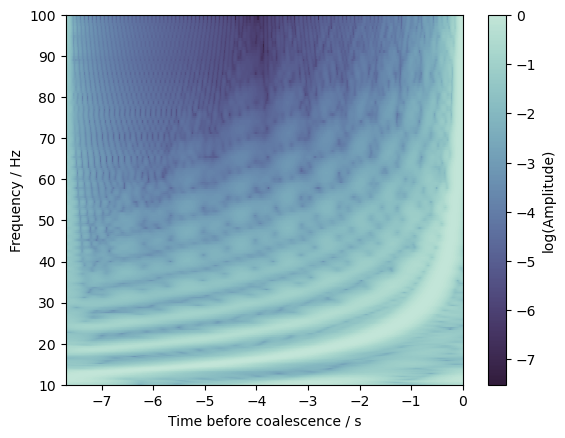

In [6]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_q_times, wf_q_freqs, np.log10(wf_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

Compare to equivalent teobresums waveform (i.e. only eccentric):

Note that this ignores the fact that the waveform models have different eccentricity definitions (which should be taken into account).

In [7]:
# Generate waveform with equivalent parameters
m1 = 20
m2 = 15
M = m1+m2
q = m1/m2
distance = 100
inclination = np.pi/2
phase = np.pi/2
ecc = 0.5
f_ref = 10
f_low = 5
sample_rate = 4096
h = gen_wf(f_low, shifted_e(f_low, f_ref, ecc), M, q, sample_rate, 'TEOBResumS', phase=phase, distance=distance, inclination=inclination)

# Set equivalent start time
if h.sample_times[-1] < wf.sample_times[-1]:
    h.append_zeros(int((wf.sample_times[-1]-h.sample_times[-1])*sample_rate*2))
h = h.time_slice(*wf.sample_times[[0, -1]])

In [8]:
# Perform qtransform
h_q_times, h_q_freqs, h_q_plane = h.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(10, 100))
h_q_amp = h_q_plane**0.5

# Normalise amplitude at each freq
h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T

Text(0, 0.5, 'Frequency / Hz')

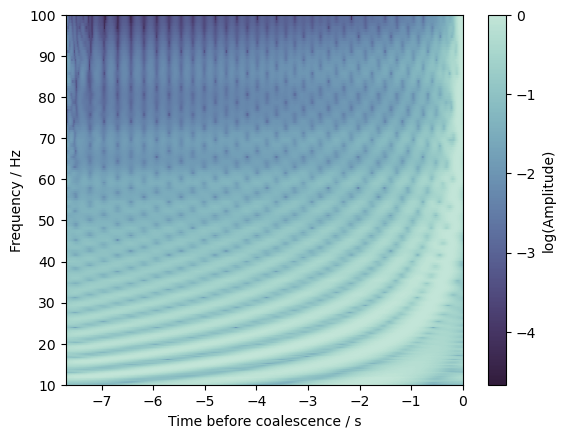

In [9]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot formatting
plt.ylim(10,100)
plt.xlim(h.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

# Waveform 2

Parameters as above except m1=16, m2=8, minimum frequency of 5Hz.

In [10]:
# Load in seobnrpe waveform
raw_wf_data = np.loadtxt('data/seobnrpe_waveform_2.txt', delimiter=',').T

# Find start time
dt = np.mean(np.diff(raw_wf_data[0]))
current_start_ind = np.max(np.where(raw_wf_data[1] == 0))+1
start_time = dt*(-len(raw_wf_data[0])+current_start_ind)

# Create pycbc timeseries object and roll to correct start point
wf_2 = TimeSeries(raw_wf_data[1]-1j*raw_wf_data[2], dt, epoch=start_time)
wf_2.roll(-current_start_ind)

In [11]:
# Perform qtransform
wf_2_q_times, wf_2_q_freqs, wf_2_q_plane = wf_2.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(10, 100))
wf_2_q_amp = wf_2_q_plane**0.5

# Normalise amplitude at each freq
wf_2_q_amp = (wf_2_q_amp.T / np.max(wf_2_q_amp, axis=1)).T

# Cut data after 0 seconds
wf_2_q_amp = wf_2_q_amp[:, wf_2_q_times<=0]
wf_2_q_times = wf_2_q_times[wf_2_q_times<=0]

# Get evolution of f_gw by maximum power at each frequency
t_arr_2 = wf_2_q_times[np.argmax(wf_2_q_amp, axis=1)]
f_gw_2 = wf_2_q_freqs[t_arr_2<-0.25]
t_arr_2 = t_arr_2[t_arr_2<-0.25]
start_ind = np.argmin(np.abs(f_gw_2 - 18))
t_arr_2 = t_arr_2[start_ind:]
f_gw_2 = f_gw_2[start_ind:]

Text(0, 0.5, 'Frequency / Hz')

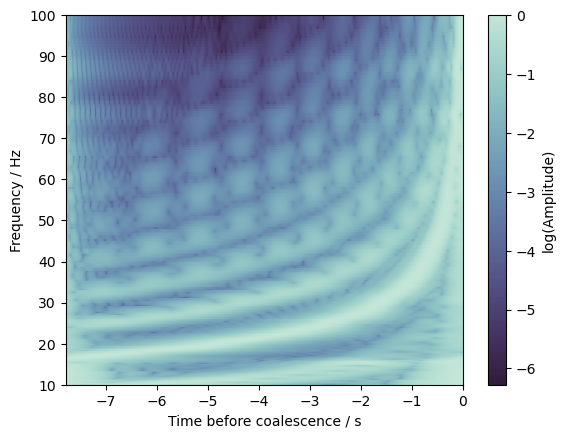

In [12]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_2_q_times, wf_2_q_freqs, np.log10(wf_2_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_2.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

Text(0, 0.5, 'Frequency / Hz')

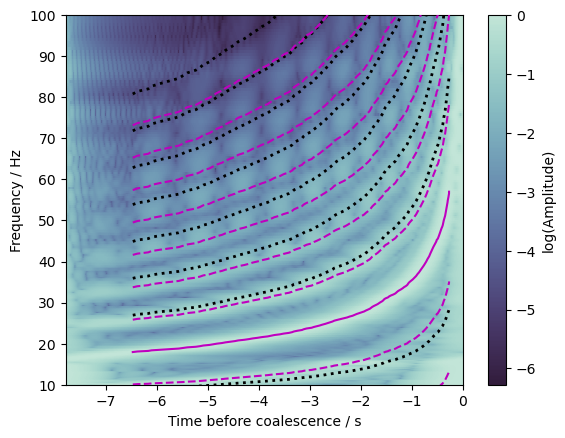

In [13]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_2_q_times, wf_2_q_freqs, np.log10(wf_2_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr_2, f_gw_2, c='m')

# Plot our harmonic frequency predictions
harm_freqs = ap_harm_freqs(f_gw_2, np.arange(-2, 8), 5, shifted_e(5, 10, 0.5), 24)
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_2, harm_freq, c='m', ls='dashed', zorder=3, label="$f_k = 2f_\mathrm{az} + kf_\mathrm{rad}$" if i == 0 else "")

# Plot integer harmonic frequency predictions
harm_freqs = int_harm_freqs(f_gw_2, np.arange(-2, 8))
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_2, harm_freq, c='k', ls='dotted', zorder=1, lw=2, label="$f_k = (2+k)f_\mathrm{az}$" if i == 0 else "")

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_2.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

We also have a non-precessing version from seobnrpe for this waveform. Has aligned spins of 0.7 (should be 0.8 to be fully consistent but model breaks with this value!)

In [14]:
# Load in seobnrpe waveform
raw_wf_data = np.loadtxt('data/seobnrpe_waveform_2_as.txt', delimiter=',').T

# Find start time
dt = np.mean(np.diff(raw_wf_data[0]))
current_start_ind = np.max(np.where(raw_wf_data[1] == 0))+1
start_time = dt*(-len(raw_wf_data[0])+current_start_ind)

# Create pycbc timeseries object and roll to correct start point
wf_2_as = TimeSeries(raw_wf_data[1]-1j*raw_wf_data[2], dt, epoch=start_time)
wf_2_as.roll(-current_start_ind)

In [15]:
# Perform qtransform
wf_2_as_q_times, wf_2_as_q_freqs, wf_2_as_q_plane = wf_2_as.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(10, 100))
wf_2_as_q_amp = wf_2_as_q_plane**0.5

# Normalise amplitude at each freq
wf_2_as_q_amp = (wf_2_as_q_amp.T / np.max(wf_2_as_q_amp, axis=1)).T

# Cut data after 0 seconds
wf_2_as_q_amp = wf_2_as_q_amp[:, wf_2_as_q_times<=0]
wf_2_as_q_times = wf_2_as_q_times[wf_2_as_q_times<=0]

# Get evolution of f_gw by maximum power at each frequency
t_arr_2_as = wf_2_as_q_times[np.argmax(wf_2_as_q_amp, axis=1)]
f_gw_2_as = wf_2_as_q_freqs
start_ind = np.argmin(np.abs(f_gw_2_as - 17.5))
t_arr_2_as = t_arr_2_as[start_ind:]
f_gw_2_as = f_gw_2_as[start_ind:]

Text(0, 0.5, 'Frequency / Hz')

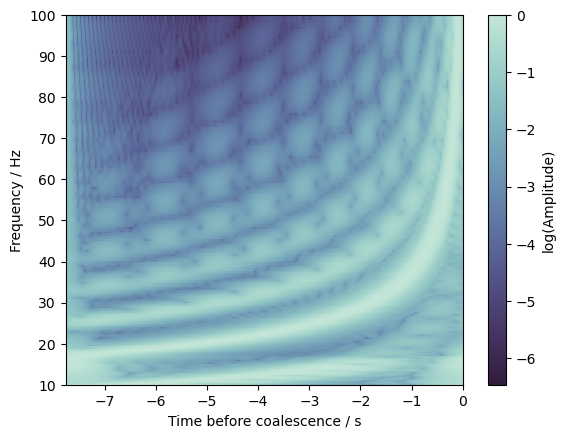

In [16]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_2_as_q_times, wf_2_as_q_freqs, np.log10(wf_2_as_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_2_as.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

Text(0, 0.5, 'Frequency / Hz')

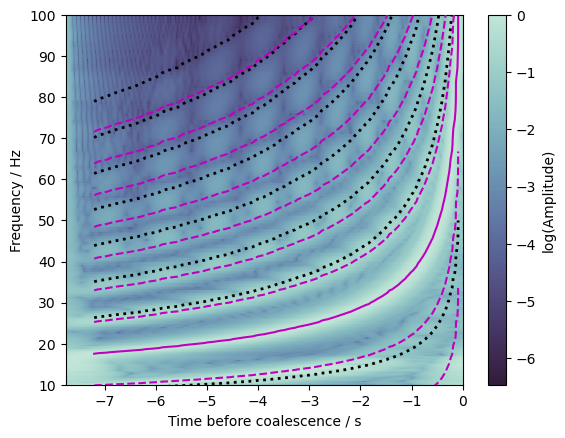

In [17]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_2_as_q_times, wf_2_as_q_freqs, np.log10(wf_2_as_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr_2_as, f_gw_2_as, c='m')

# Plot our harmonic frequency predictions
harm_freqs = ap_harm_freqs(f_gw_2_as, np.arange(-2, 8), 5, shifted_e(5, 10, 0.5), 24)
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_2_as, harm_freq, c='m', ls='dashed', zorder=3, label="$f_k = 2f_\mathrm{az} + kf_\mathrm{rad}$" if i == 0 else "")

# Plot integer harmonic frequency predictions
harm_freqs = int_harm_freqs(f_gw_2_as, np.arange(-2, 8))
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_2_as, harm_freq, c='k', ls='dotted', zorder=1, lw=2, label="$f_k = (2+k)f_\mathrm{az}$" if i == 0 else "")

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_2_as.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

Let's try a teobresums waveform with higher modes included.

In [18]:
# Parameters
f_ref = 10
e = 0.2
f_low = 5
chirp = 10
q = 2
inclination = np.pi/2
mode_list = [[1,1],[2,1],[2,2],[3,1],[3,2],[3,3],[4,1],[4,2],[4,3],[4,4],[5,1],[5,2],[5,3],[5,4],[5,5]] # All up to l=5

In [19]:
# Gen wf and qtransform
s_e = shifted_e(f_low, f_ref, e)
h = gen_wf(f_low, s_e, chirp2total(chirp,q), q, 1024, 'TEOBResumS', inclination=inclination, mode_list=mode_list)
h_q_times, h_q_freqs, h_q_plane = h.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(5, 100))
h_q_amp = h_q_plane**0.5

# Normalise amplitude at each freq
h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T

# Cut data before -10.5 seconds
h_q_amp = h_q_amp[:, h_q_times>=-10.5]
h_q_times = h_q_times[h_q_times>=-10.5]

Text(0, 0.5, 'Frequency / Hz')

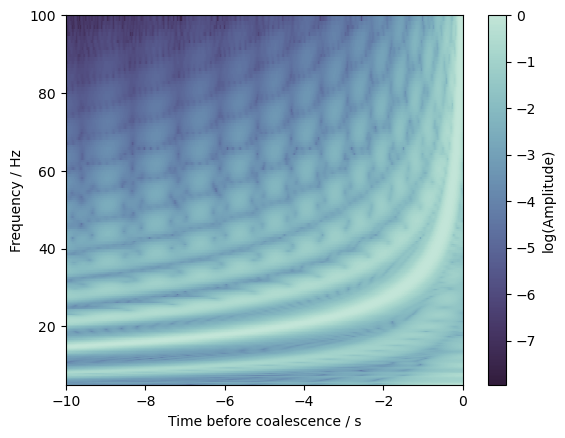

In [20]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot formatting
plt.ylim(5,100)
plt.xlim(-10, 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

See the same vertical features only when including higher modes.

# 22 only waveform

Now with same parameters as before except only the 22 mode and 0.7 spin magnitude in both for consistency.

In [4]:
# Load in seobnrpe waveform
raw_wf_data = np.loadtxt('data/seobnrpe_waveform_22_only.txt', delimiter=',').T

# Find start time
dt = np.mean(np.diff(raw_wf_data[0]))
current_start_ind = np.max(np.where(raw_wf_data[1] == 0))+1
start_time = dt*(-len(raw_wf_data[0])+current_start_ind)

# Create pycbc timeseries object and roll to correct start point
wf_22 = TimeSeries(raw_wf_data[1]-1j*raw_wf_data[2], dt, epoch=start_time)
wf_22.roll(-current_start_ind)

In [14]:
# Perform qtransform
wf_22_q_times, wf_22_q_freqs, wf_22_q_plane = wf_22.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(10, 100))
wf_22_q_amp = wf_22_q_plane**0.5

# Normalise amplitude at each freq
wf_22_q_amp = (wf_22_q_amp.T / np.max(wf_22_q_amp, axis=1)).T

# Cut data after 0 seconds
wf_22_q_amp = wf_22_q_amp[:, wf_22_q_times<=0]
wf_22_q_times = wf_22_q_times[wf_22_q_times<=0]

# Get evolution of f_gw by maximum power at each frequency
t_arr_22 = wf_22_q_times[np.argmax(wf_22_q_amp, axis=1)]
f_gw_22 = wf_22_q_freqs[t_arr_22<-0.25]
t_arr_22 = t_arr_22[t_arr_22<-0.25]
start_ind = np.argmin(np.abs(f_gw_22 - 17.3))
t_arr_22 = t_arr_22[start_ind:]
f_gw_22 = f_gw_22[start_ind:]

Text(0, 0.5, 'Frequency / Hz')

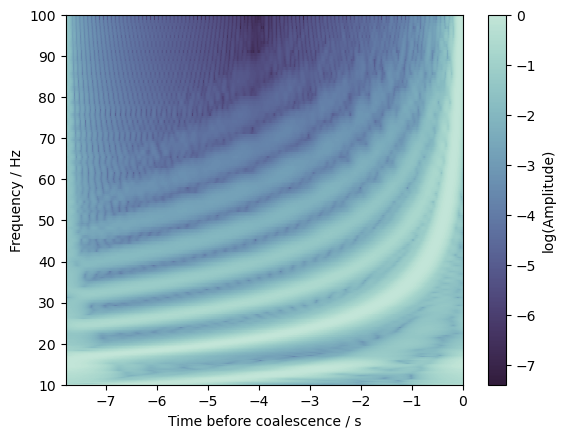

In [7]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_22_q_times, wf_22_q_freqs, np.log10(wf_22_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_22.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

Text(0, 0.5, 'Frequency / Hz')

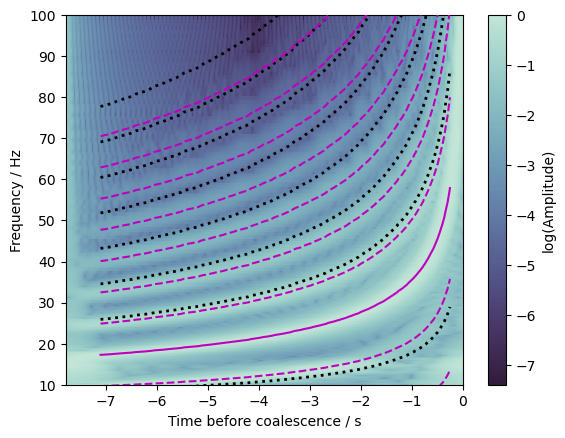

In [15]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_22_q_times, wf_22_q_freqs, np.log10(wf_22_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr_22, f_gw_22, c='m')

# Plot our harmonic frequency predictions
harm_freqs = ap_harm_freqs(f_gw_22, np.arange(-2, 8), 5, shifted_e(5, 10, 0.5), 24)
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_22, harm_freq, c='m', ls='dashed', zorder=3, label="$f_k = 2f_\mathrm{az} + kf_\mathrm{rad}$" if i == 0 else "")

# Plot integer harmonic frequency predictions
harm_freqs = int_harm_freqs(f_gw_22, np.arange(-2, 8))
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_22, harm_freq, c='k', ls='dotted', zorder=1, lw=2, label="$f_k = (2+k)f_\mathrm{az}$" if i == 0 else "")

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_22.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

And now for aligned spin version

In [4]:
# Load in seobnrpe waveform
raw_wf_data = np.loadtxt('data/seobnrpe_waveform_22_only_as.txt', delimiter=',').T

# Find start time
dt = np.mean(np.diff(raw_wf_data[0]))
current_start_ind = np.max(np.where(raw_wf_data[1] == 0))+1
start_time = dt*(-len(raw_wf_data[0])+current_start_ind)

# Create pycbc timeseries object and roll to correct start point
wf_22_as = TimeSeries(raw_wf_data[1]-1j*raw_wf_data[2], dt, epoch=start_time)
wf_22_as.roll(-current_start_ind)

In [5]:
# Perform qtransform
wf_22_as_q_times, wf_22_as_q_freqs, wf_22_as_q_plane = wf_22_as.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(10, 100))
wf_22_as_q_amp = wf_22_as_q_plane**0.5

# Normalise amplitude at each freq
wf_22_as_q_amp = (wf_22_as_q_amp.T / np.max(wf_22_as_q_amp, axis=1)).T

# Cut data after 0 seconds
wf_22_as_q_amp = wf_22_as_q_amp[:, wf_22_as_q_times<=0]
wf_22_as_q_times = wf_22_as_q_times[wf_22_as_q_times<=0]

# Get evolution of f_gw by maximum power at each frequency
t_arr_22_as = wf_22_as_q_times[np.argmax(wf_22_as_q_amp, axis=1)]
f_gw_22_as = wf_22_as_q_freqs[t_arr_22_as<-0.25]
t_arr_22_as = t_arr_22_as[t_arr_22_as<-0.25]
start_ind = np.argmin(np.abs(f_gw_22_as - 18))
t_arr_22_as = t_arr_22_as[start_ind:]
f_gw_22_as = f_gw_22_as[start_ind:]

Text(0, 0.5, 'Frequency / Hz')

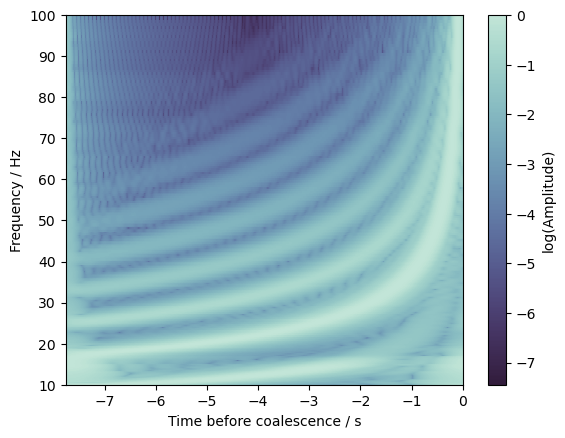

In [6]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_22_as_q_times, wf_22_as_q_freqs, np.log10(wf_22_as_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_22_as.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

Text(0, 0.5, 'Frequency / Hz')

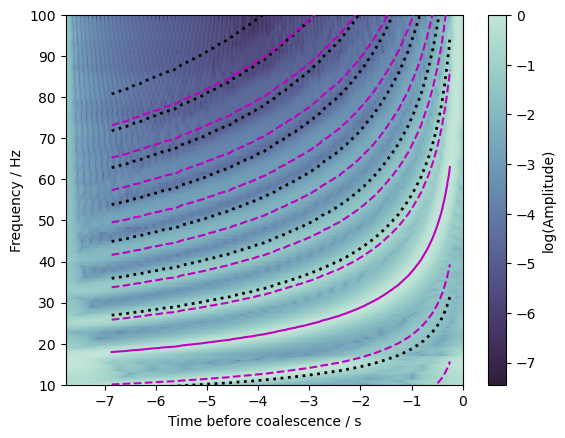

In [7]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(wf_22_as_q_times, wf_22_as_q_freqs, np.log10(wf_22_as_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr_22_as, f_gw_22_as, c='m')

# Plot our harmonic frequency predictions
harm_freqs = ap_harm_freqs(f_gw_22_as, np.arange(-2, 8), 5, shifted_e(5, 10, 0.5), 24)
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_22_as, harm_freq, c='m', ls='dashed', zorder=3, label="$f_k = 2f_\mathrm{az} + kf_\mathrm{rad}$" if i == 0 else "")

# Plot integer harmonic frequency predictions
harm_freqs = int_harm_freqs(f_gw_22_as, np.arange(-2, 8))
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr_22_as, harm_freq, c='k', ls='dotted', zorder=1, lw=2, label="$f_k = (2+k)f_\mathrm{az}$" if i == 0 else "")

# Plot formatting
plt.ylim(10,100)
plt.xlim(wf_22_as.sample_times[0], 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')